<a href="https://colab.research.google.com/github/151ali/lr-pytorch/blob/main/8_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

paper : [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)

In [1]:
import torch
import torch.nn as nn

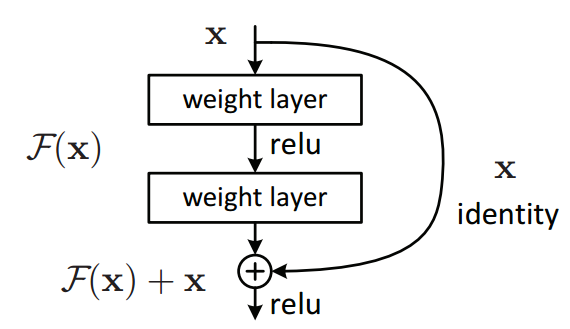

In [2]:
class ResidualBlock(nn.Module):
  def __init__(self,
    in_channels,
    out_channels,
    identity_downsample=None, # !
    stride=1             
  ):
    super(ResidualBlock, self).__init__()

    self.expansion = 4
    self.conv1 = nn.Conv2d(
        in_channels, out_channels, kernel_size=1, stride=1, padding=0, bias=False
    )
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.conv2 = nn.Conv2d(
        out_channels,
        out_channels,
        kernel_size=3,
        stride=stride,
        padding=1,
        bias=False
    )
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.conv3 = nn.Conv2d(
        out_channels,
        out_channels * self.expansion,
        kernel_size=1,
        stride=1,
        padding=0,
        bias=False
    )
    self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
    self.relu = nn.ReLU()
    self.identity_downsample = identity_downsample
    self.stride = stride

  def forward(self, x):
    identity = x.clone()

    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)
    x = self.conv3(x)
    x = self.bn3(x)

    if self.identity_downsample is not None:
        identity = self.identity_downsample(identity)

    x += identity
    x = self.relu(x)
    return x

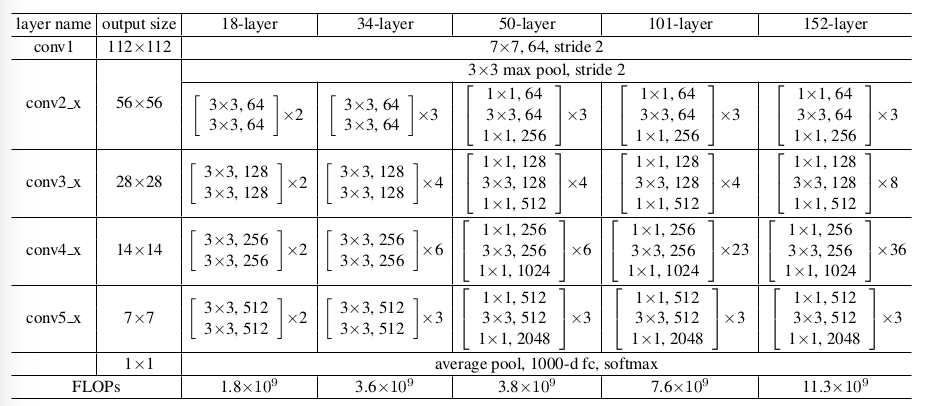

In [3]:
class ResNet(nn.Module):
  """
  resnet- 50
  layer = [3, 4, 6, 3]
  """
  def __init__(self,
               resblock,
               layers,
               image_channels,
               num_classes
  ):
    super(ResNet, self).__init__()
    self.in_channels = 64
    self.conv1   = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
    self.bn1     = nn.BatchNorm2d(64)
    self.relu    = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    # ResNet Layers
    self.layer1 = self._make_layer(resblock,layers[0], out_channels=64, stride=1)
    self.layer2 = self._make_layer(resblock,layers[1], out_channels=128, stride=2)
    self.layer3 = self._make_layer(resblock,layers[2], out_channels=256, stride=2)
    self.layer4 = self._make_layer(resblock,layers[3], out_channels=512, stride=2)

    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.fc = nn.Linear(512*4, num_classes)

  def _make_layer(self, ResidualBlock, num_residual_blocks, out_channels, stride):
    identity_downsample = None
    layers = []

    if stride != 1 or self.in_channels != out_channels * 4:
      identity_downsample = nn.Sequential(
          nn.Conv2d(self.in_channels, out_channels*4,  kernel_size=1, stride=stride),
          nn.BatchNorm2d(out_channels * 4)
      )

    layers.append(
        ResidualBlock(self.in_channels, out_channels, identity_downsample, stride)
    )
    self.in_channels = out_channels * 4 #256

    for i in range(num_residual_blocks -1 ):
      layers.append(
        ResidualBlock(self.in_channels, out_channels)
      )
    return nn.Sequential(
        *layers
    )

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)

    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.fc(x)

    return x

In [4]:
model = ResNet(ResidualBlock, [3,4,6,3],image_channels=3, num_classes=10)

In [5]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNo

In [6]:
x = torch.randn(1,3,224,224)

In [8]:
model(x)

tensor([[ 0.2783, -0.7439, -0.2310,  0.2499,  1.1204,  0.6455, -1.0021,  0.3919,
          0.2179,  0.5987]], grad_fn=<AddmmBackward>)